In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import glob
import sys
from utils import *


from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics


import keras
from keras import backend as K
from functools import partial, update_wrapper
from itertools import product
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten, Reshape, BatchNormalization
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Conv2D, AveragePooling1D, MaxPooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.utils import multi_gpu_model, np_utils


sns.set(style="darkgrid")
sys.path.append("../../dsmuc/")
import dsmuc.io as io
import dsmuc.preprocessing as pp
import dsmuc.features as ff
import dsmuc.custom as cs

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Inputs

In [2]:
raw_windows_path = "/home/ahmet/notebooks/data/G9_data/Raw/snippets/"
processed_file_path = "/home/ahmet/notebooks/data/G9_data/processed.csv"

In [3]:
columns = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']

In [4]:
win_paths = glob.glob(raw_windows_path+'*/*.csv')
print("Found {} windows".format(len(win_paths)))

Found 34470 windows


In [5]:
%%time
win_list = [pd.read_csv(win_paths[i], index_col='date', parse_dates=True) for i in range(len(win_paths))]

CPU times: user 45 s, sys: 1.7 s, total: 46.7 s
Wall time: 46.7 s


In [6]:
len(win_list)

34470

In [7]:
win_list[1].head()

,accX,accY,accZ,gyroX,gyroY,gyroZ,subject_id,label
date,,,,,,,,
2017-12-20 07:21:47.030,-9.797073,-2.552219,0.057461,0.030651,0.086162,0.327219,11,5
2017-12-20 07:21:47.052,-9.797073,-2.533065,0.071826,0.001889,0.083498,0.255847,11,5
2017-12-20 07:21:47.076,-9.619903,-2.542642,0.167594,-0.018883,0.077107,0.180213,11,5
2017-12-20 07:21:47.093,-9.543288,-2.537854,0.177171,-0.023677,0.069650,0.108307,11,5
2017-12-20 07:21:47.111,-9.504981,-2.523489,0.215478,-0.005568,0.063258,0.039598,11,5


### Check Frequency of the watch

In [55]:
df = win_list[0]

In [56]:
df['date'] = df.index
time_delta = (df['date'].diff(1).values/1000000).astype(float)[1:]

In [57]:
time_delta.mean()

21.387096774193548

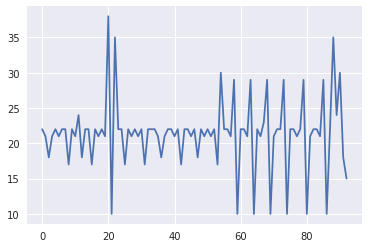

In [58]:
plt.plot(time_delta)

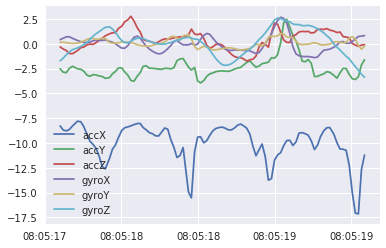

In [79]:
plt.plot(pd.read_csv('/home/ahmet/notebooks/data/G9_data/Raw/snippets/walking/10_10.csv', index_col='date', parse_dates=True)[columns])
plt.legend(columns)

In [87]:
a = pd.read_csv('/home/ahmet/notebooks/data/G9_data/Raw/snippets/walking/10_10.csv', index_col='date', parse_dates=True)[columns]
a.shape

(98, 6)

In [80]:
def get_raw(win_list):
    # Get data in raw format for models
    
    win_len = len(win_list)
    X , y , s=[], [], []
    index = 0
    for win in win_list:
        # Append data, label and subject id 
        X.append(win[columns].values)
        y.append(win['label'][0])
        s.append(win['subject_id'][0])
        index += 1
        if index%200 ==0:
            print(index,"of windows out of ", len(win_list))
    return np.array(X), np.array(y).astype(int), np.array(s).astype(int)

def get_processed(processed_file_path = None, win_list = None):
    if processed_file_path:
        df = pd.read_csv(processed_file_path, delimiter=',', decimal=".",header=[0,1])
        
    elif win_list:  
        print("This will take some time ~5 mins")
        i = 0
        print("indexing windows")
        for win in win_list:
            i += 1
            win['win_index'] = i
        df_win = pd.concat(win_list)
        ff.interested_cols = [ 'accX', 'accY', 'accZ', 'gyroX','gyroY', 'gyroZ', 'win_index']
        feature_list = ['aoa','ate','apf','rms','std','minimax', 'energy','min','max']
        preserved_features = ['start','subject_id','label']

        df = ff.extract_features(df_win, feature_list=feature_list , preserved_features=preserved_features)

    else:
        raise(ValueError("Please provide a processed file path or windows list"))
    
    df.dropna(axis=0, how='any', inplace=True)
    X = df[df.columns[:-3]].values
    y = df['label'].astype(int).values
    s = df['subject_id'].astype(int).values
    return X, y, s , df
    

In [81]:
X_raw, y_raw, s_raw = get_raw(win_list)

200 of windows out of  34470
400 of windows out of  34470
600 of windows out of  34470
800 of windows out of  34470
1000 of windows out of  34470
1200 of windows out of  34470
1400 of windows out of  34470
1600 of windows out of  34470
1800 of windows out of  34470
2000 of windows out of  34470
2200 of windows out of  34470
2400 of windows out of  34470
2600 of windows out of  34470
2800 of windows out of  34470
3000 of windows out of  34470
3200 of windows out of  34470
3400 of windows out of  34470
3600 of windows out of  34470
3800 of windows out of  34470
4000 of windows out of  34470
4200 of windows out of  34470
4400 of windows out of  34470
4600 of windows out of  34470
4800 of windows out of  34470
5000 of windows out of  34470
5200 of windows out of  34470
5400 of windows out of  34470
5600 of windows out of  34470
5800 of windows out of  34470
6000 of windows out of  34470
6200 of windows out of  34470
6400 of windows out of  34470
6600 of windows out of  34470
6800 of window

In [82]:
X_prep, y_prep, s_prep, df = get_processed(processed_file_path=processed_file_path)

In [83]:
u,c = np.unique(y_prep, return_counts=True)
labels = np.array(['walking','walking upstairs','walking downstairs','sitting','standing','lying'])
data = pd.DataFrame([labels[u-1],c]).transpose()
data.columns = ['class', 'counts']

In [84]:
data

,class,counts
0,walking,3217
1,walking upstairs,4069
2,walking downstairs,3926
3,sitting,8978
4,standing,4299
5,lying,4932


## CNN

In [118]:
def CNN1():
    # 77% accuracy
    model = Sequential()
    model.add(Conv1D(8,
                    64,
                     input_shape=(timesteps,1),
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(16,
                    16,
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(64,
                    8,
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(128,
                    4,
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(256,
                    2,
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model

def CNN2():
    # 77% accuracy
    model = Sequential()
    model.add(Conv2D(8,
                    (65,6),
                     input_shape=(timesteps,6,1),
                     padding='same',
                     strides = (1,1)
                    ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4,1)))
    model.add(Conv2D(16,
                    (33,3),
                     padding='same',
                     strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(Conv2D(32,
                    (5,3),
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model

## RNN

In [95]:
def RNN1():
    # 85% accuracy
    model = Sequential()
    model.add(Conv1D(8,
                    64,
                     input_shape=(timesteps,1),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(16,
                    16,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(64,
                    8,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(128,
                    4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(LSTM(64))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model
def RNN2():
    # 85% accuracy
    model = Sequential()
    model.add(Conv2D(8,
                    (64,3),
                     input_shape=(timesteps,6,1),
                     padding='valid',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(4,1)))
    model.add(Conv2D(16,
                    (16,3),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Reshape(target_shape=(1,16)))   
    model.add(LSTM(64))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model

## MLP

In [96]:
def MLP():
    model = Sequential()
    model.add(Dense(512, input_shape =(timesteps,)))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256))
    model.add(Dense(256))
    model.add(Dense(32))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()
    return model

In [134]:
# Custom loss function with costs

def w_categorical_crossentropy(y_true, y_pred):
    weights = np.ones((6,6))
    weights[5, 3] = 5.0 # Predicting  class 5 as 3 will be punished 
    
    nb_cl = weights.shape[1]#len(weights[0,:])
    y_pred = K.cast(y_pred, K.floatx())
    y_pred_max = K.max(y_pred, axis=1)#returns maximum value along an axis in a tensor
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
#     weights = K.cast(weights, K.floatx())
#     y_true = K.cast(y_true, K.floatx())
    final_mask = K.zeros_like(y_pred[:, 0])
#     print(y_pred_max_mat, weights, y_true)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] *y_pred_max_mat[:, c_p]*y_true[:, c_t])
    #ypred_tensor=K.constant(y_pred,dtype=K.set_floatx('float32'))
    #ytrue_tensor=K.constant(y_true,dtype=K.set_floatx('float32'))
    return K.cast(K.categorical_crossentropy(y_true,y_pred) * final_mask, K.floatx())

In [135]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [144]:
selected_model = 'CNN1'

dl_models = ['CNN1', 'MLP_Raw', 'RNN1', 'CNN2', 'RNN2']
#LOO-Validation on each subject
if selected_model in dl_models:
    X = X_raw
    y = y_raw
    s = s_raw
else:
    X = X_prep
    y = y_prep
    s = s_prep

    
batch_size = 400
n_classes = 6
    
subject_list = np.unique(s_raw)
y_test_all = []
y_pred_all = []
y_pred_all_post = []
np.random.seed(44)
iterations = shuffle(np.array(list(itertools.combinations(subject_list, 2))))

it_index = iterations[:50]
i = 0
for subject in it_index[:1]: # two combination of tested subjects
    if os.path.exists('weights.hdf5'):
        os.remove('weights.hdf5')
    i += 1 
    subject[0] = '1111'
    subject[1] = '2222'
    X_test = X_raw
    y_test = y_raw
    print("=====================>", i)
    print('Model tested on subjects with no : ', subject)
    mask_test = np.logical_or(s==subject[0], s== subject[1])
    mask_training = np.logical_and(s!=subject[0], s!= subject[1])
    
    if not selected_model in dl_models : # Models will train on processed features
        
        X_test = X[np.ravel(mask_test),:]
        y_test = np.ravel(y[np.ravel(mask_test),:] -1)
        X_training = X[np.ravel(mask_training),:]
        y_training = np.ravel(y[np.ravel(mask_training),:] -1)
        print("Test set and training set proportion : ",float(X_test.shape[0])/X_training.shape[0] )
        class_weight = get_class_weights(y_training)
        
        if selected_model == "LogReg":
            model = LogisticRegression(class_weight = class_weight, penalty='l1')
        elif selected_model == "SVM":
            model = svm.SVC( class_weight = class_weight, probability=True)
        elif selected_model == 'RForest':
            model = RandomForestClassifier(max_depth=10, n_estimators=20, class_weight=class_weight)
        
        model.fit(X_training, y_training)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
    else: # Models will train on raw data
#         X_test = X[np.ravel(mask_test)]
#         y_test = np.ravel(y[np.ravel(mask_test)] -1)
        X_training = X[np.ravel(mask_training)]
        y_training = np.ravel(y[np.ravel(mask_training)] -1)
        # convert class vectors to binary class matrices
        y_training = one_hot(y_training)
        y_test = one_hot(y_test -1)
    
        print("Test set and training set proportion : ",float(X_test.shape[0])/X_training.shape[0] )
        
    
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=25,
                              verbose=0, mode='auto'),
            keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)]
        
        X_training = keras.preprocessing.sequence.pad_sequences(X_training, maxlen=100, dtype='float32',
            padding='pre', truncating='pre', value=0.)
        X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=100, dtype='float32',
            padding='pre', truncating='pre', value=0.)
        
        
        
        if selected_model =='CNN1':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape[0], -1,1)
            X_test = X_test.reshape(test_shape[0], -1,1)
            timesteps = len(X_training[0])
            model = CNN1()
        elif selected_model =='CNN2':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape+(1,))
            X_test = X_test.reshape(test_shape+ (1,))
            timesteps = len(X_training[0])
            model = CNN2()
        elif selected_model =='RNN1':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape[0], -1,1)
            X_test = X_test.reshape(test_shape[0], -1,1)
            timesteps = len(X_training[0])
            model = RNN1()
        elif selected_model =='RNN2':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape+(1,))
            X_test = X_test.reshape(test_shape+ (1,))
            timesteps = len(X_training[0])
            model = RNN2()
        elif selected_model =='MLP_Raw':
            
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape[0], -1)
            X_test = X_test.reshape(test_shape[0], -1)
            timesteps = len(X_training[0])
            model = MLP()
            
        elif selected_model =='MLP_Features':
            X_test = X[np.ravel(mask_test),:]
            y_test = np.ravel(y[np.ravel(mask_test),:] -1)
            X_training = X[np.ravel(mask_training),:]
            y_training = np.ravel(y[np.ravel(mask_training),:] -1)
            
            
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_train = X_train.reshape(train_shape[0], -1)
            X_test = X_test.reshape(test_shape[0], -1)
            timesteps = len(X_training[0])
            model = MLP()
            
        # Compile model
#         multi_model = multi_gpu_model(model = model, gpus = 1)
        sgd = keras.optimizers.SGD(lr=0.01, clipnorm=1., decay=0.005)
        model.compile(loss=w_categorical_crossentropy,
                  optimizer='rmsprop',
                  metrics=['accuracy'])
        history =model.fit(X_training,
                  y_training,
                  batch_size=batch_size,
                  validation_data = (X_test, y_test),
                  epochs=100,
                  callbacks=callbacks)
        
        
        model.load_weights('weights.hdf5')
        y_score = model.predict_proba(X_test)
        print("")
        
    y_pred_all.extend(np.argmax(y_score, axis=1))
    y_test_all.extend(list(np.argmax(y_test, axis=1)))
    y_pred_all_post.extend(list(np.argmax(pd.rolling_mean(y_score, 50,min_periods=1), axis=1)))
    '''plt.figure()
    plt.plot(pd.rolling_mean( y_score, 50,min_periods=1), "-")
    plt.xlim([0, 1.5*len(y_score)])
    plt.legend(['walking',
            'walking upstairs',
            'walking downstairs',
            'resting',
            'standing''], loc='upper_left')
    a = np.asarray(y_test).astype(np.int)
    y_ticks = np.asarray(['walking',
            'walking upstairs',
            'walking downstairs',
            'resting',
            'standing'])[a]
    plt.plot(y_ticks)
    plt.xlim([0, 1.5*len(y_score)])'''
#     plt.savefig('Figures/'+str(subject[0])+'_'+str(subject[1])+'.png')

=====================> 1
Model tested on subjects with no :  [1111 2222]
Test set and training set proportion :  1.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_296 (Conv1D)          (None, 537, 8)            520       
_________________________________________________________________
batch_normalization_311 (Bat (None, 537, 8)            32        
_________________________________________________________________
activation_311 (Activation)  (None, 537, 8)            0         
_________________________________________________________________
max_pooling1d_296 (MaxPoolin (None, 268, 8)            0         
_________________________________________________________________
conv1d_297 (Conv1D)          (None, 253, 16)           2064      
_________________________________________________________________
batch_normalization_312 (Bat (None, 253, 16)           64        
_________________________

KeyboardInterrupt: 

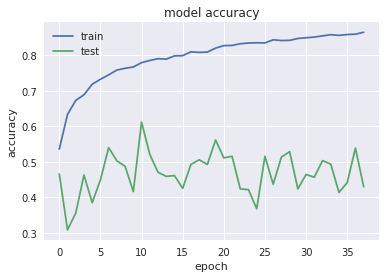

In [138]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

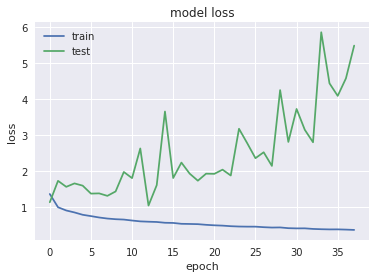

In [139]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization


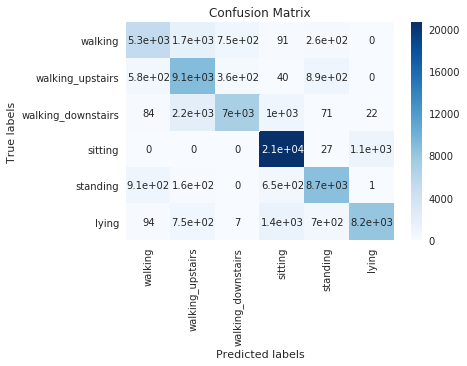

Normalized confusion matrix


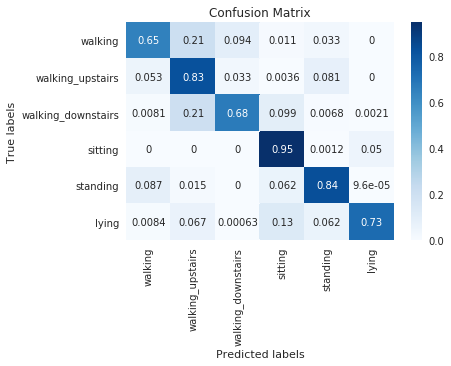

In [140]:
label_dict = {1:'walking',
             2:'walking_upstairs',
             3:'walking_downstairs',
             4:'sitting',
             5:'standing',
             6:'lying'}
class_names = list(label_dict.values())


cnf_matrix = confusion_matrix(y_test_all, y_pred_all_post)
np.set_printoptions(precision=2)

save_with_name = selected_model
# Plot non-normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=False)

# Plot normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=True)
plt.savefig(save_with_name+'.png')
plt.show()

In [130]:
true_pos = np.diag(cnf_matrix).sum()
accuracy = true_pos/float(cnf_matrix.sum())
print('Overall accuracy of the Model', accuracy)

Overall accuracy of the Model 0.7188883423512051


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_all, y_pred_all_post,target_names=class_names))

In [ ]:
auc_roc_plot(one_hot(np.array(y_test_all)), np.array(y_score_all), None)